**In this notebook, we discover the data and make some analysis that helps us choose the models that we want to test.**


In [2]:
import os
import pandas as pd
from langdetect import detect, DetectorFactory
import matplotlib.pyplot as plt
import re


In [5]:
data_file = 'data/train.csv'

In [6]:
df = pd.read_csv(data_file)

# Distribution of the classes


Text(0.5, 1.0, 'Distribution of the sentiments')

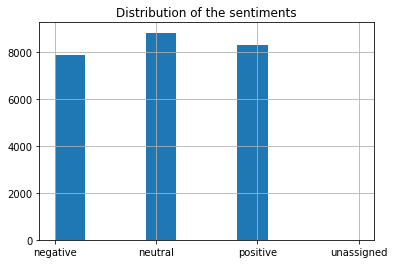

In [7]:
df['sentiment'].hist()
plt.title('Distribution of the sentiments')

In [8]:
df['sentiment'].value_counts()


neutral       8823
positive      8318
negative      7858
unassigned       1
Name: sentiment, dtype: int64

Basically the dataset in **balanced** where the number of examples classified as "neutral" is slightly bigger than the number of "positive" and "negative" examples.
We can see that there is on example which is attributed to the class **"unassigned"**  that we start by removing.


In [9]:
df = df[df['sentiment'] != 'unassigned']

# Language analysis

In [10]:
def detect_language(x):
    try :
        return detect(x)
    except :
        return 'Others'


In [11]:
languages = df['content'].apply(detect_language)


In [12]:
print(sum(languages == 'Others')/df.shape[0], '% are classified as others which are contents ith emojis and or written in kmerian')

0.002280091203648146 % are classified as others which are contents ith emojis and or written in kmerian


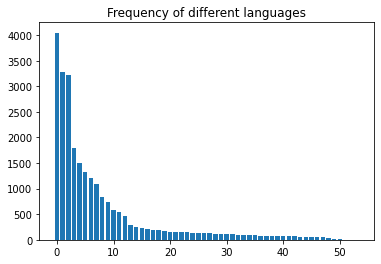

We can see that a great variance in the language's frequency between the 54 different languages present in our dataset: while the most frequent language reprensent 0.16% of our training dataset with 4048 content, the most rare language only appears 2 times.
Next, we take a closer look on the most frequent languages


In [13]:
v = pd.value_counts(languages)
plt.bar(range(v.shape[0]), v.values)
plt.title('Frequency of different languages')
plt.show()
print("We can see that a great variance in the language's frequency between the {} different languages present in our dataset:".format(len(v)),
      "while the most frequent language reprensent {}% of our training dataset with {} content, the most rare language only appears {} times.".format(round(v[0]/df.shape[0], 2), v[0], v[-1]))
print('Next, we take a closer look on the most frequent languages')

In [14]:
languages_code = {'en':'english',
                 'ru': 'russian', 
                 'id': 'Indonesian',
                 'ar': 'Arabic',
                 'fr': 'French',
                 'es': 'Spanish',
                 'pt': 'Portuguese',
                 'ko': 'Korean',
                 'zh-cn': 'Chinese',
                 'ja': 'Japanese',
                 'it': 'Italian',
                 'de': 'German',
                 'th': 'Thai',
                 'tr': 'Turkish',
                 'tl': 'Tagalog',
                 'so': 'Somali',
                 'vi': 'Vietnamese',
                 'pl': 'Polish',
                 'et': 'Estonian',
                 'nl': 'Dutch/Flemish'}
                 
                 


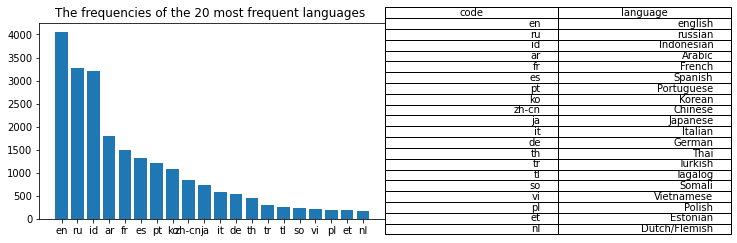

In [15]:
plt.bar(v[:20].index, v[:20].values)
table = plt.table(cellText=list(languages_code.items()),
                  colLabels=['code', 'language'], loc = 'right')
plt.subplots_adjust(left=0.1, bottom=0.2)
plt.title('The frequencies of the 20 most frequent languages ')
plt.show()


Not only our dataset in a multilingual one with more than 50 languages.
--> We need to use a **multilingual model** or combine train a **different model for each language** and combine it with a **language detection** model.

However, there are two facts that make the second option unrealisable:
- Some of the most frequent languages, such as the Japanese, Chinese and the Arabic, are "rare" languages that are underrepresented in the literature which makes it difficult to find a model pretrained on those languages
- The open source language detection models are computionnaly expensive and not very performant.

--> For those reasons, we choose to use a **unique multilingual model**.

# Length analysis 

In [16]:
content_lengths = df['content'].apply(lambda x: len(x.split()))

In [17]:
content_lengths.describe()

count    24999.000000
mean        18.658666
std         45.455195
min          1.000000
25%          5.000000
50%         10.000000
75%         18.000000
max       2994.000000
Name: content, dtype: float64

We can see that 75% of the contents are composed of less than 18 words. 

--> This motivates us to use **bert-based** language models since the **sequences length is not too big** and best-based model have limited sequence size.

# Evaluation process and conclusion

We handle the problem as a multi-class classification task with three classes: 'neutral', 'positive' and 'negative'.
For both classes 'positive' and "negative', 
we will be calculating the precision and recall per class and the f1 score. 



**Business assumption:**
We may assume that the most harmful misclassification for synthesio's clients is missing 'negative' sentiments in the online shared content, either about their brand or about competitors. In fact, detecting the negative signals in social media about the brand itself is the primary key and the first step to improve the product and fit the users' expectations, and capturing the negative signals about competitors is the primary key to acquire new market shares. 
--> We may use this assumtion to give extra-attention to the **recall of the "negative" class'** and to the **precesion of the "positive" class** by applying a weighted average. 

--> We will only use this weighted average if we find two models that have comparable scores (precision per class, recall per class and f1 score) 